In [83]:
%reload_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

from online_sorter_qtui import spike_data
from pyneurode.spike_sorter import *
import numpy as np 
import pickle
from sklearn import metrics
from tqdm.notebook import tqdm
import seaborn as sns

import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

%R require(ggplot2)
%R require(repr)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1], dtype=int32)

In [134]:
# load data
data_list = []
segment_count = 0
with open('data_packets_t4.pkl','rb') as f:
    while True:
        try:
            data_list.append(pickle.load(f))
            segment_count +=1
        except EOFError:
            break
    
    print(f'Reached end. Total segment: {segment_count}')


Reached end. Total segment: 27121


In [135]:
Fs = 30000
spikes_data = [d['spike'] for d in data_list if 'spike' in d.keys()]
df = makeSpikeDataframe(spikes_data)
df.head()

,spike_waveform,time,electrode_ids,channel_ids,spike_id,timestamps
0,"[8.20976, 10.928137, 11.087367, 8.436979, 4.39...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,177215
1,"[3.3335688, -5.7106113, -12.615346, -6.0080943...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,195374
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,196279
3,"[-7.5335927, -8.355244, -5.8849335, -4.337479,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,196895
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,197579


(27, 13849600)
176000
(3128, 1)


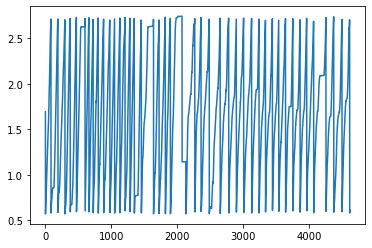

In [136]:
# collect the animal position
adc_data = [d['data'] for d in data_list if 'data' in d]
adc_data = np.concatenate(adc_data,1)
print(adc_data.shape)
start_timestamp = data_list[1]['data_timestamp']
print(start_timestamp)

# Extract and time-bin the data
segment_size = int(Fs*time_bin)
position, _ = simpleDownSample(adc_data[20,:,None], segment_size)
print(data_ds.shape)
plt.plot(position)

### Helper function

In [137]:
def sort_spikes(df_ref, df2sort):
    df_ref = df_ref.copy()
    df2sort = df2sort.copy()
    df_sorted = sort_all_electrodes(df_ref)

    # calculate templates
    df_cluster = df_sorted.groupby('cluster_id').mean().reset_index()
    cluster_electrode_ids = dict(zip(df_cluster.cluster_id.values, df_cluster.electrode_ids.values))

    spike_waveforms = np.stack(df_sorted.spike_waveform_aligned.values)
    cluster_id = df_sorted.cluster_id.values

    # Calculate spike templates
    templates,template_cluster_id = calculate_spike_template(spike_waveforms,cluster_id)
    template_electrode_id = np.array([int(cluster_electrode_ids[i]) for i in template_cluster_id])
    
    # template matching
    df_sorted_all = template_match_all_electrodes(df2sort, templates, template_electrode_id)
    
    return df_sorted, df_sorted_all,template_cluster_id



## Compare sorting results with all offline sorting and online sorting

In [90]:
ars = []
ars_valid = []
no_cluster = []
numSpikes2train = []
numSpikeRange = range(100,5000,500)

for num2sort in tqdm(numSpikeRange):
    
    # random sampling to remove dependence on sequence of appearance of spikes
    for _ in tqdm(range(10)):
        df_sample = df.sample(frac=1).reset_index(drop=True)
        #sort
        df_ref_partial, df_online_partial = sort_spikes(df_sample.iloc[:num2sort], df_sample.iloc[num2sort:])
        df_ref_all, df_online_all = sort_spikes(df_sample, df_sample.iloc[num2sort:])

        no_cluster.append(len(df_ref_partial.cluster_id.unique()))

        cluster_id_online =df_online_partial.label_tm.values.astype(int)
        cluster_id_offline = df_ref_all.iloc[num2sort:].cluster_id.values.astype(int)


        ars.append(metrics.adjusted_rand_score(cluster_id_offline,
            cluster_id_online))

        valid_idx = np.argwhere(cluster_id_offline!=-1)

        ars_valid.append(metrics.adjusted_rand_score(cluster_id_offline[valid_idx].squeeze(),
            cluster_id_online[valid_idx].squeeze()))
        
        numSpikes2train.append(num2sort)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:52<00:00, 47.26s/it]


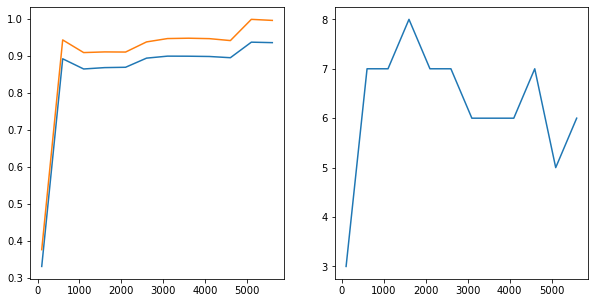

In [73]:
x = range(100,6000,500)
fig,ax = plt.subplots(1,2,figsize=(5*2,5))
ax[0].plot(x,ars)
ax[0].plot(x,ars_valid)
ax[1].plot(x,no_cluster)

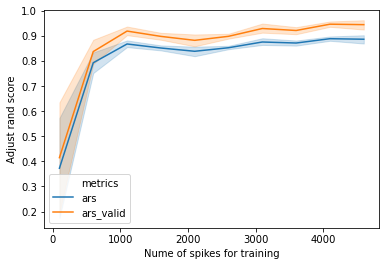

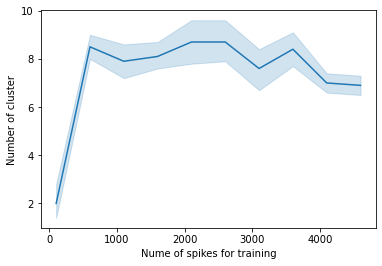

In [103]:
df_metrics = pd.DataFrame({'ars':ars,
                          'ars_valid':ars_valid,
                          'no_cluster':no_cluster,
                           'numSpikes2train':numSpikes2train})
df_metrics = df_metrics.melt(id_vars='numSpikes2train',var_name='metrics')
df_metrics_ars = df_metrics[df_metrics.metrics.isin(['ars','ars_valid'])]
ax = sns.lineplot(x='numSpikes2train',y='value',hue='metrics',data=df_metrics_ars)
ax.set_ylabel('Adjust rand score')
ax.set_xlabel('Nume of spikes for training')
plt.savefig('figures/ars.png')

plt.figure()
df_metrics_cluster = df_metrics[df_metrics.metrics.isin(['no_cluster'])]
ax = sns.lineplot(x='numSpikes2train',y='value',data=df_metrics_cluster)
ax.set_ylabel('Number of cluster')
ax.set_xlabel('Nume of spikes for training')
plt.savefig('figures/cluster_no.png')

In [106]:
x=np.array([1,2,3,1,2,3,1,2,3])
y=np.array([2,3,4,2,3,4,1,2,4])
metrics.adjusted_rand_score(x,y)

0.5833333333333334

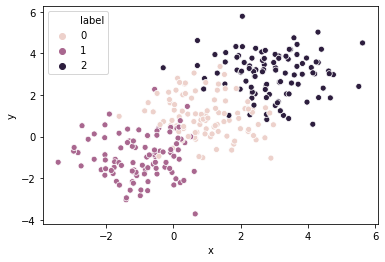

In [119]:
from sklearn import datasets
def plotCluster(X,y):
    df = pd.DataFrame({'x':X[:,0], 'y':X[:,1]})
    df['label'] = y
    sns.scatterplot(x='x',y='y', hue='label',data=df)

center = np.array([[1,1],[-1,-1],[3,3]])
X,y = datasets.make_blobs(n_samples=300, n_features=2,centers=center, cluster_std=1)
plotCluster(X,y)


## Compare tuning curve

In [138]:
num2sort = 2000
df_ref, df_online,template_cluster_id = sort_spikes(df.iloc[:num2sort], df.iloc[num2sort:])

In [139]:
# make firing rate array
Fs = 30000
time_bin_start = 0
time_bin = 0.1
spike_time = (df_online.timestamps.values - start_timestamp)/Fs #shift timestamp
bins = np.arange(time_bin_start, spike_time.max(), time_bin )
spk_train, skp_time_event=sort2spiketrain(template_cluster_id, df_online.label_tm, spike_time, bins)


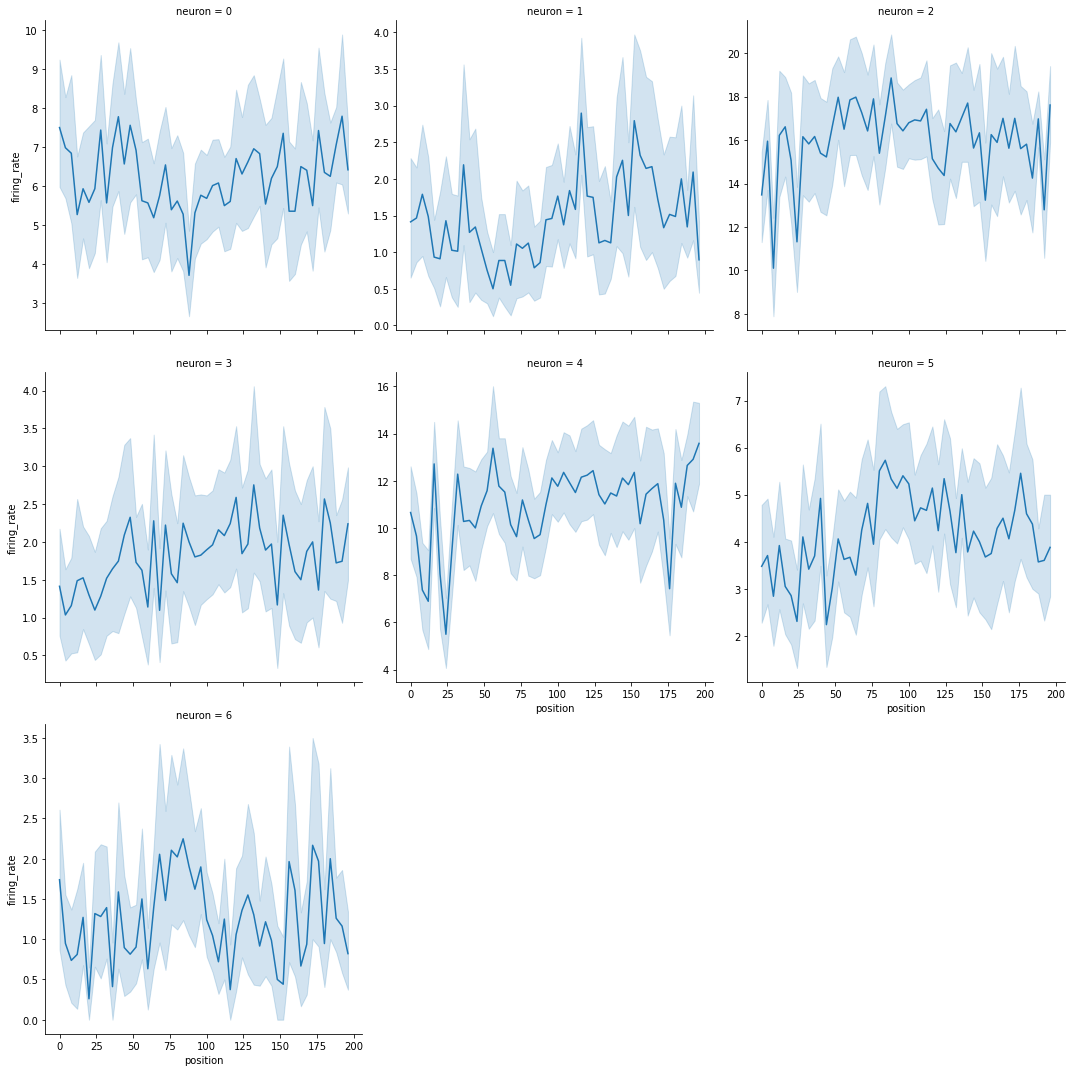

In [140]:
# calculate tuning curve

df_online_tc = makeTuningDataframe(position,spk_train.T,time_bin)

sns.relplot(x='position',y='firing_rate',col='neuron',col_wrap=3, kind="line",
    facet_kws = {'sharey':False},data=df_online_tc)


R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



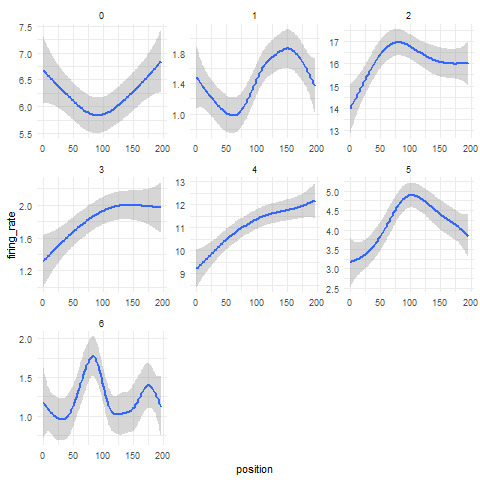

In [141]:
%%R -i df_online_tc
ggplot(df_online_tc) +
    geom_smooth(aes(x=position,y=firing_rate)) +
    facet_wrap(~neuron,scale='free') +
    theme_minimal()
# ggsave('online_tuningcurve.pdf')

## Offline sorting using spike interface

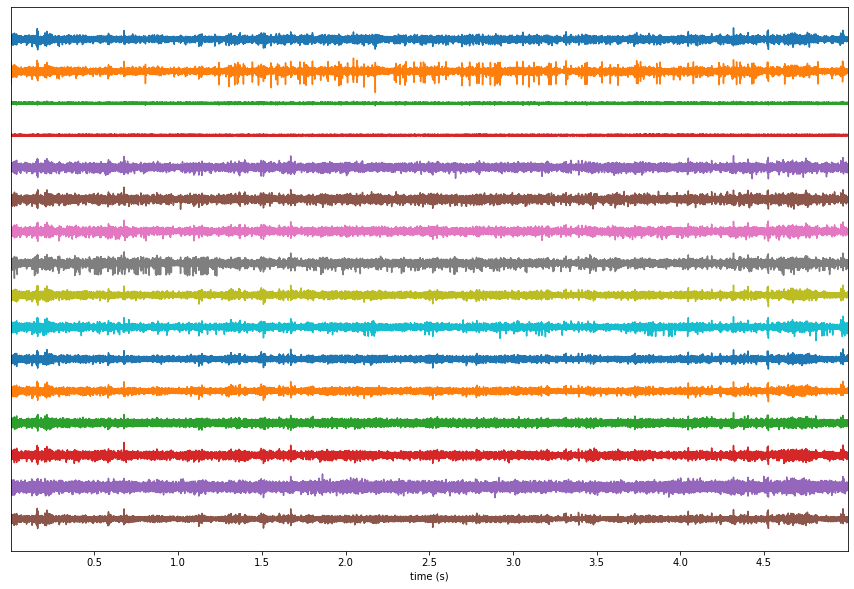

In [142]:
neuroData = adc_data[:16,:]
recording = se.NumpyRecordingExtractor(timeseries=neuroData,sampling_frequency=Fs)
recording.load_probe_file('tetrode_16.prb')
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
fig,ax = plt.subplots(figsize=(15,10))
sw.plot_timeseries(recording_f,trange=[0,5],ax=ax);

In [143]:
 #required for mountasort to store intermediate data
%env TEMPDIR=C:\tmp
ms4_params = ss.get_default_params('mountainsort4')
ms4_params['curation']=True
ms4_params['adjust_radius']  = 100
sorting_MS4_2 = ss.run_mountainsort4(recording=recording,output_folder='sorting_tmp',verbose=True)

env: TEMPDIR=C:\tmp
WARNING! No channel location given. Add dummy location.
Using 2 workers.
Using tmpdir: C:\tmp\tmp6fpmdcde
Num. workers = 2
Preparing C:\tmp\tmp6fpmdcde/timeseries.hdf5...
'end_frame' set to 13849600
Preparing neighborhood sorters (M=16, N=13849600)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: C:\tmp\tmp6fpmdcde
mountainsort4 run time 145.57s


In [144]:
# curation
sorting_ms4_curated = st.curation.threshold_snrs(sorting=sorting_MS4_2, recording = recording,
  threshold = 4, threshold_sign='less',
    max_snr_spikes_per_unit=100, apply_filter=False) #remove when less than threshold
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_firing_rates(sorting_ms4_curated,
    threshold=0.5, threshold_sign='less', duration_in_frames=recording.get_num_frames())
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_isi_violations(sorting_ms4_curated, 
    threshold = 0.9,duration_in_frames=recording.get_num_frames(), threshold_sign='greater' )
print(sorting_ms4_curated.get_unit_ids())


Impossible to delete temp file: C:\Users\teristam\AppData\Local\Temp\tmpbjb6p_g6 Error [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\teristam\\AppData\\Local\\Temp\\tmpbjb6p_g6\\waveforms_1.raw'
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]


In [145]:
time_bin_start = 0
bins = np.arange(time_bin_start, adc_data.shape[1]/Fs, time_bin )

# extract the spike train, and bin it in time
spiketrain = []
for i in sorting_ms4_curated.get_unit_ids():
    spk_train = sorting_ms4_curated.get_unit_spike_train(i)
    spk_train = (spk_train - start_timestamp)/Fs #convert to s
    spiketrain.append(np.histogram(spk_train,bins)[0])

spiketrain=np.stack(spiketrain)    

# make frame for plotting
df_ms4 = makeTuningDataframe(position, spiketrain.T,time_bin)


R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



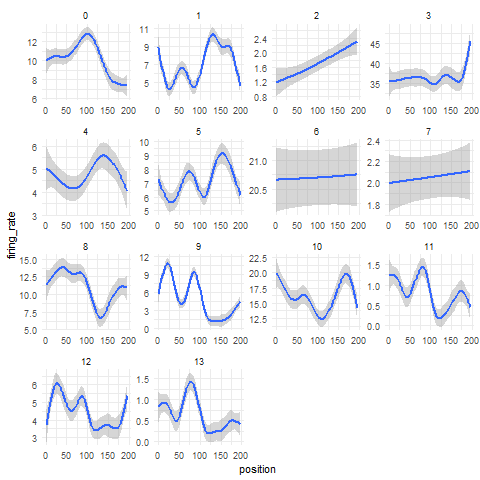

In [146]:
%%R -i df_ms4
options(repr.plot.width=12, repr.plot.height=8)

ggplot(df_ms4) +
    geom_smooth(aes(x=position,y=firing_rate)) +
    facet_wrap(~neuron,scale='free') +
    theme_minimal()
    
# ggsave('ms4_tuningcurve.pdf')